In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import uproot
print(sys.executable)

/usr/bin/python3


In [2]:
# No beam effects and crossing angle hepmc file: 
# Taken from https://dtn01.sdcc.bnl.gov:9000/minio/eictest/ATHENA/WG/BeamEffects/
no_effects_source = "/home/romanov/eic/data/test_headon_25mRad_18x275.hepmc"

# Full pythia8 with beam effects file: 
# Taken from https://dtn01.sdcc.bnl.gov:9000/minio/eictest/ATHENA/EVGEN/DIS/NC/18x275/minQ2=10/
full_py8_source = "/home/romanov/eic/data/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
executable = "/home/romanov/eic/afterburner/cpp/cmake-build-debug/benchmark/benchmark"
process_limit = 10000

# We compare setups here: 
# 1. No beam effects, No afterburner
# 2. No beam effects + afterburner
# 3. Full beam effects (No afterburner obviously)

# Each setup will produce hepmc and .root file + command to run converter/afterburner

# 1. No effects, No afterburner
no_effects_out = "no_effects.hepmc"
no_effects_root = no_effects_out + ".root"
no_effects_cmd = f"{executable} {no_effects_source} --ab-off --limit={process_limit} -o {no_effects_out}"

# 2. No beam effects run through afterburner
afterburner_out = "afterburner.hepmc"
afterburner_root = afterburner_out + ".root"
afterburner_cmd = f"{executable} {no_effects_source} --limit={process_limit} -o {afterburner_out}"

# 3. Full beam effects (No afterburner obviously)
full_py8_out = "full_eff.hepmc"
full_py8_root = full_py8_out + ".root"
full_py8_cmd = f"{executable} {full_py8_source} --ab-off --limit={process_limit} -o {full_py8_out}"


The next one will trigger simulations for 1. no effects 

In [3]:
print("\n\n", no_effects_cmd)
!{no_effects_cmd}
print("\n\n", afterburner_cmd)
!{afterburner_cmd}
print("\n\n", full_py8_cmd)
!{full_py8_cmd}



 /home/romanov/eic/afterburner/cpp/cmake-build-debug/benchmark/benchmark /home/romanov/eic/data/test_headon_25mRad_18x275.hepmc --ab-off --limit=10000 -o no_effects.hepmc
AFTERBURNER CONFIGURATION
Vertex distribution width  x: 0.00671564, y: 0.000601655, z: 3.16228, t: 0.105482
Vertex distribution function: Gauss
Beam direction: A  theta-phi = 0.025, 0
Beam direction: B  theta-phi = 3.14159, 0
Beam divergence: A X-Y = 0.000119, 0.000119
Beam divergence: B X-Y = 0.000211, 0.000152
Beam angle shift as linear function of longitudinal vertex position : A X-Y = -2.40385e-06, 0
Beam angle shift as linear function of longitudinal vertex position: B X-Y = -3.28947e-06, 0
Events parsed: 1000
Events parsed: 2000
Events parsed: 3000
Events parsed: 4000
Events parsed: 5000
Events parsed: 6000
Events parsed: 7000
Events parsed: 8000
Events parsed: 9000
Events parsed: 10000
Event limit reached:->events_parsed(10000) >= events_limit(10000)<-. Exit.


 /home/romanov/eic/afterburner/cpp/cmake-build-d

In [4]:
!ls -latrh
# !rm *.root *.hepmc

total 207M
drwxrwxr-x 7 romanov romanov 4.0K Sep 14 22:02 ..
-rw-rw-r-- 1 romanov romanov 1.6K Sep 15 16:26 gen_hepmc_event.py
-rw-rw-r-- 1 romanov romanov   72 Sep 15 22:13 Untitled.ipynb
drwxrwxr-x 2 romanov romanov 4.0K Sep 15 22:13 .ipynb_checkpoints
-rw-rw-r-- 1 romanov romanov 101K Sep 16 00:18 compare.ipynb
-rw-rw-r-- 1 romanov romanov  69M Sep 16 00:18 no_effects.hepmc
-rw-r--r-- 1 romanov romanov  59K Sep 16 00:18 no_effects.hepmc.root
-rw-rw-r-- 1 romanov romanov  70M Sep 16 00:18 afterburner.hepmc
-rw-r--r-- 1 romanov romanov  57K Sep 16 00:18 afterburner.hepmc.root
drwxrwxr-x 3 romanov romanov 4.0K Sep 16 00:18 .
-rw-rw-r-- 1 romanov romanov  69M Sep 16 00:18 full_eff.hepmc
-rw-r--r-- 1 romanov romanov  58K Sep 16 00:18 full_eff.hepmc.root


In [5]:
no_effects_file = uproot.open(no_effects_root)
no_effects_file.keys()
afterburner_file = uproot.open(afterburner_root)
full_py8_file = uproot.open(full_py8_root)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f18be2faf70>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

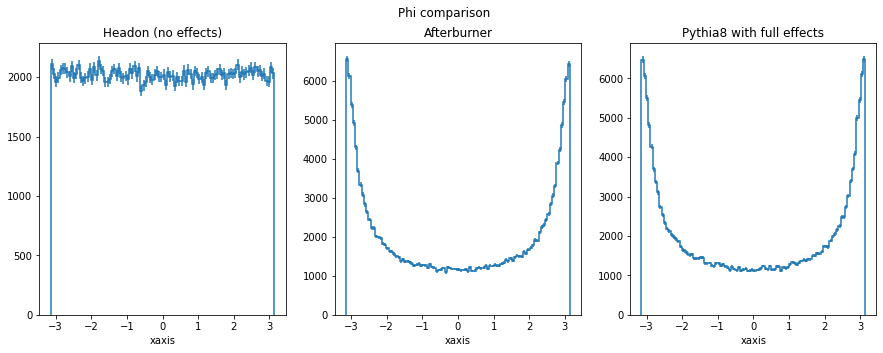

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Phi comparison')

ax1.set_title("Headon (no effects)")
no_effects_file['partPhi'].to_hist().plot(ax=ax1)

ax2.set_title("Afterburner")
afterburner_file['partPhi'].to_hist().plot(ax=ax2)

ax3.set_title("Pythia8 with full effects")
full_py8_file['partPhi'].to_hist().plot(ax=ax3)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f18ac711a00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

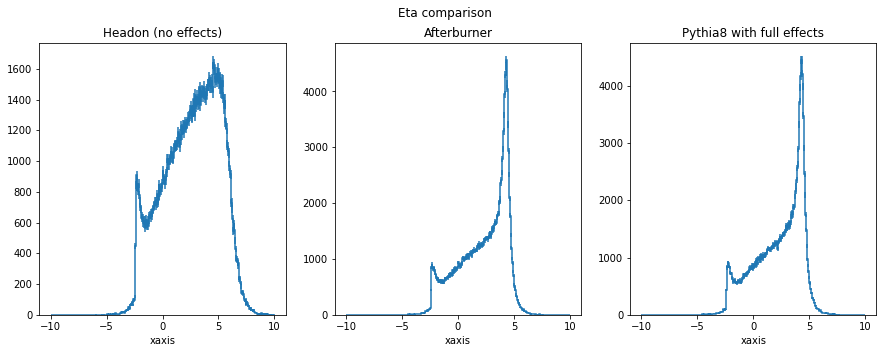

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Eta comparison')

ax1.set_title("Headon (no effects)")
no_effects_file['partEta'].to_hist().plot(ax=ax1)

ax2.set_title("Afterburner")
afterburner_file['partEta'].to_hist().plot(ax=ax2)

ax3.set_title("Pythia8 with full effects")
full_py8_file['partEta'].to_hist().plot(ax=ax3)

([StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f18ac270580>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)], [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f18ac1aad30>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)])


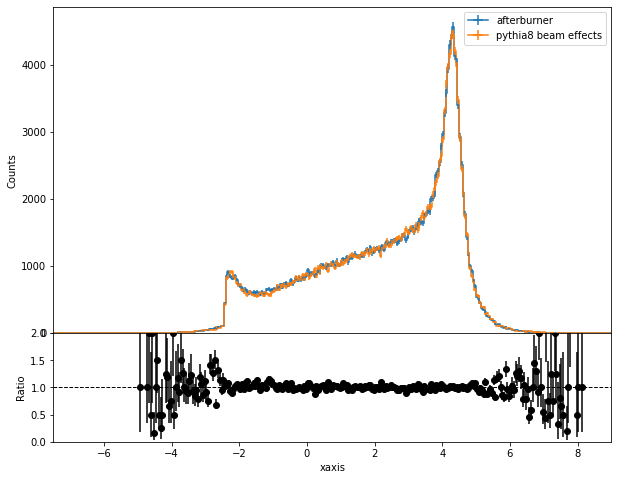

In [8]:
fig = plt.figure(figsize=(10, 8))

ab_eta_hist = afterburner_file['partEta'].to_hist()
py8_eta_hist = full_py8_file['partEta'].to_hist()

# Comparison plot
top_art, bottom_art = ab_eta_hist.plot_ratio(
    py8_eta_hist,
    rp_num_label="afterburner",
    rp_denom_label="pythia8 beam effects")

bottom_art.line.axes.set_ylim(0, 2)
bottom_art.line.axes.set_xlim(-7.5, 9)
print(top_art)